In [1]:
#load libraries
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Introduction
This project will explore if the player's age and duration spent in the game is predictive of a player subscribing to a game-related newsletter. We will only explore the `players` dataset to help us understand which characteristics can help the research group become more efficient in recruiting and distributing their resources. 

Here is the link to my GitHub respository:
https://github.com/amyxu777-cmd/dsci_individual.git

In [8]:
#read and inspect the datasets
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
head(players)
summary(players)

# gets us the median 
played_hours_median <- players_data|>
    select(played_hours)|>
    map_df(median, na.rm = TRUE)
played_hours_median

# calculating the mean
players_mean <- players |>
    select(played_hours, Age)|>
    map_df(mean, na.rm = TRUE)|>
    round(2)
players_mean

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

played_hours
<dbl>
0.1


played_hours,Age
<dbl>,<dbl>
5.85,21.14


# Data description
The `players` dataframe contains 196 observations and 7 columns.
|Variables|Type|Description|Notes/Potential issues|
|:----------------:|:----------:|:--------------|:--------------|
|`experience`  |character|Tells us the player's experience level |Notes: Rated out of five levels (Beginner, Amateur, Regular, Veteran, and Pro)|
|`subscribe`   | logical |Tells us if the player has subscribed to the newsletter yet.|Notes: 144 of the players have and 52 have not.|
|`hashedEmail` |character|Identifies the players|Notes: each one is unique for each player|
|`played_hours`|numeric  |Total time spent in game (hours)|Mean: 5.8 hours, min: 0 hours, max: 223.1 hours|
|`name`        |character|Player's name|Notes: also unique for players|
|`gender`      |character|Player's gender|Notes: contains more than 2 values (female, male) |
|`Age`         |numeric  |Player's age (years)|Issue: contains 2 missing values (NAs)|

There are some values in the dataset that skews the data and can cause the analysis of the data to be unreliable. One example of this is 2 the missing values in the `Age` column. We can fix this in many ways, either by using `na.rm = TRUE` to tell R to ignore the missing data, or take the mean of the values in the column and use it in place of the missing data. Another example is seen in the `played_hours` column where the median value is 0.1 while the mean is 5.85. The data is skewed by a few values that reach close to 223. Possible solutions to this problem can include listing the values close to 223 as outliers or using a logarithm scale. 

# Question
**Can the player's age and number of hours spent in the game predict whether or not they will subscribe to the game-related newsletter?**

This is a predictive question. We will use the `players` data frame wtih `Age` and `played_hours` as our predictors and `subscribe` as our response variable (the one we want to predict). It looks like every column corresponds to a variable and each row corresponds to an observation and every cell has a singular value. This suggests that the data frame is tidy.

To clean up, I will take out the unrelated columns, keeping only the relevant ones (`Age`, `played_hours`, and `subscribe`). Since we want to work with `subscribe` as a categorical variable, I will use the function `mutate` to turn `subscribe` into factor type data. To resolve any `NA`s when manipulating `Age` I will implement `na.rm = TRUE` in the argument.

In [10]:
#mutated dataframe
players_data <- players |> 
    select(subscribe, played_hours, Age)|>
    mutate(subscribe = as_factor(subscribe))|>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players_data)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Yes,30.3,9
Yes,3.8,17
No,0.0,17
Yes,0.7,21
Yes,0.1,21
Yes,0.0,17


# Exploratory Data Analysis and Visualization


Table 1: mean values of each quantitative variable in the `players` dataset 
|Variable|Mean Value|
|:--------:|:----------:|
|`Age`|21.14|
|`played_hours`|5.85|

To explore the predictors of subscription, I examined how these variables differ between subscribers and non-subscribers. A class imbalance was observed in the `subscribe` variable, with 144 “Yes” responses (73.5%) and 52 “No” responses (26.5%), indicating that most players chose to subscribe.

The `Age` distribution (plot named `dist_Age_sub`) shows that the majority of the players are in their early twenties, and both, the subscribers and non-subscribers, are similar in age, indicating that age is not a powerful indicator. 

In contrast, the distribution of `played_hours` (plot named `dist_hours_sub`) has a large right skew with most players have little playtime, while a few have very high values. We can check for the median value of total hours played which is 0.1. Comparing this value to the mean of 5.85 suggests a very skewed data.

Subscribers play for longer periods of time, suggesting a probable positive relationship between total playtime and subscription likelihood.

Finally, a scatter plot of `Age` vs. `Played_hours` reveals no clear linear pattern, but rather a concentration of subscribers among higher-playtime individuals.


played_hours,Age
<dbl>,<dbl>
5.85,21.14


played_hours
<dbl>
0.1


subscribe,count,percentage
<fct>,<int>,<dbl>
No,52,26.53061
Yes,144,73.46939


[1] 196

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


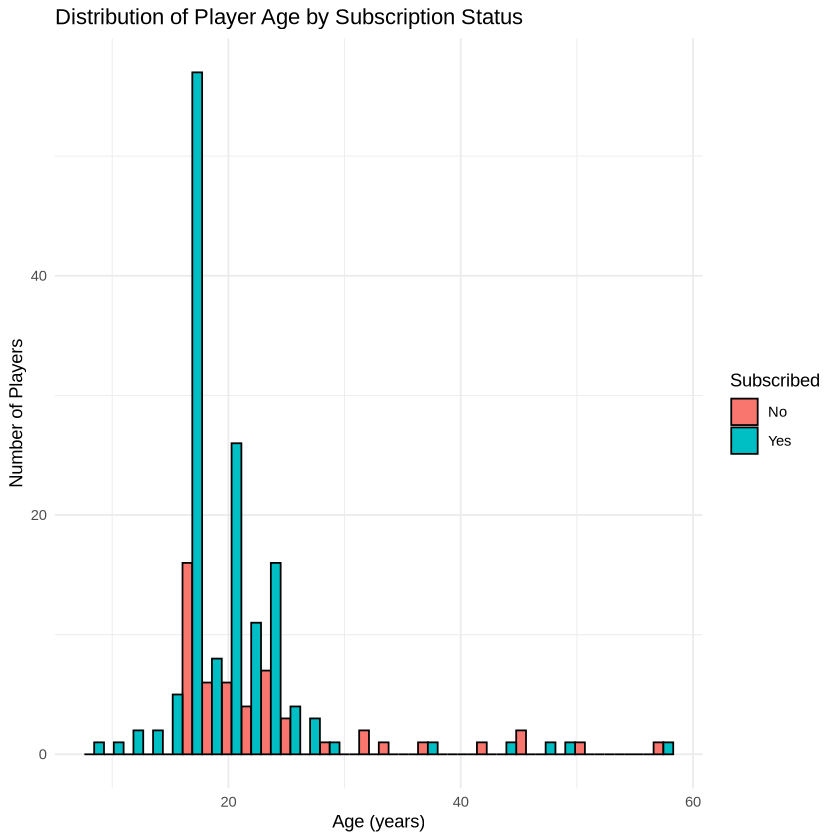

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


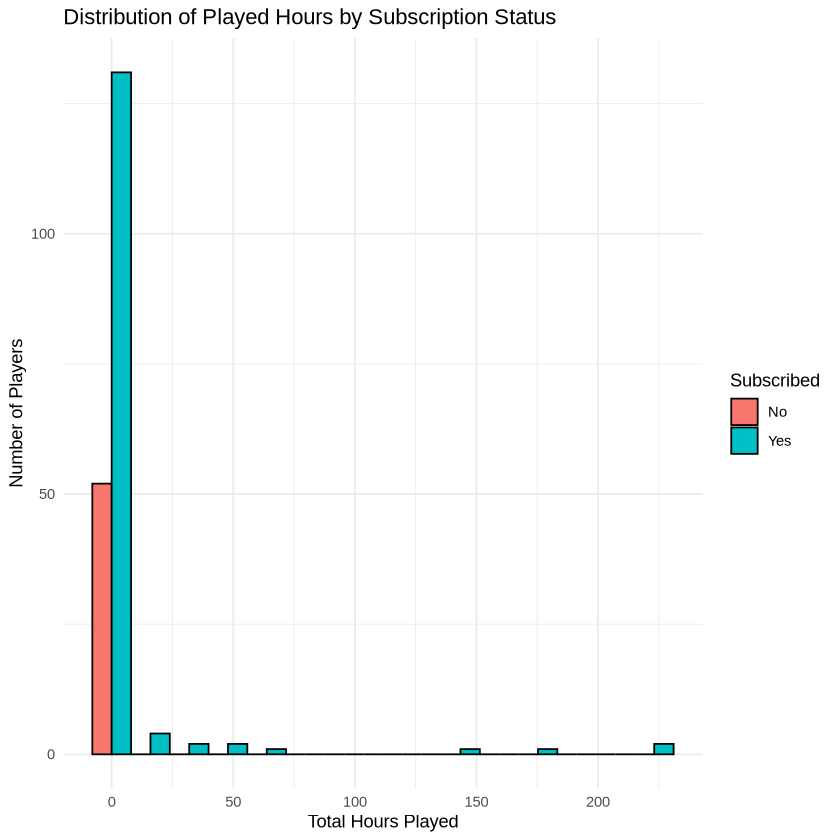

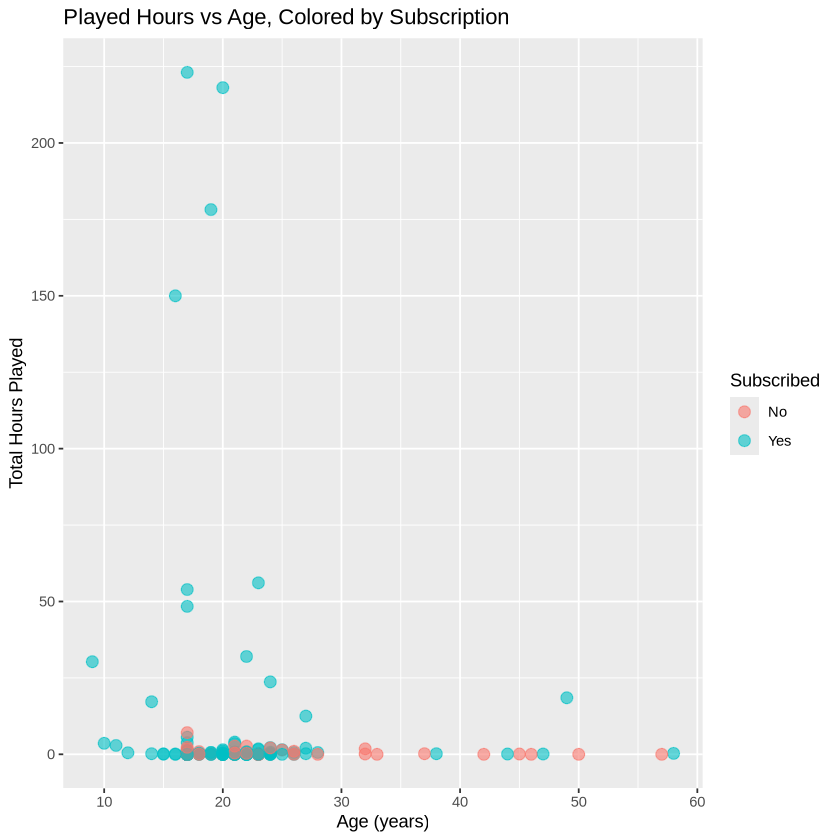

In [6]:
#checks class imbalance
num_obs <- nrow(players_data)
players_data |>
  group_by(subscribe) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
num_obs

dist_Age_sub <- players_data |>
  ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(position = "dodge", bins = 30, color = "black") +
  labs(
    title = "Distribution of Player Age by Subscription Status",
    x = "Age (years)",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()
dist_Age_sub

dist_hours_sub <- players_data |>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "dodge", bins = 15, color = "black") +
  labs(
    title = "Distribution of Played Hours by Subscription Status",
    x = "Total Hours Played",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()
dist_hours_sub

hours_vs_Age <- players_data |>
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6, size = 3) +
  labs(
    title = "Played Hours vs Age, Colored by Subscription",
    x = "Age (years)",
    y = "Total Hours Played",
    color = "Subscribed"
  )
hours_vs_Age

# Method and plan
The question "Can the player's age and number of hours spent in the game predict whether or not they will subscribe to the game-related newsletter?" requires us to use *K-NN Classification* where we will work with variables, `Age` and `hours_played` which we call predictors to predict the value of the response variable `subscribe`. 
- In using the K-NN Classification method I'm hoping that it will catch some nonlinear trends between `hours_played` and `Age`.

1. **Splitting the data**
- The data will first be split into the training set and the testing set.
- Randomly splitt the data into 70% for training and 30% for testing.


2. **Preprocessing**
- Next, we will scale and center the training set first.
- The standardization preprocessor should be created using only the training data, avoiding any influence from the test data.

3. **Build the classifier**
- Create the recipe and model specification.
  - When creating the recipe, we will need to balance the classes of `subscribe` with the `step_upsample` function.
- Combine the two into a workflow.
- use `fit` with the training set to train the classifier.

4. **Tune the classifier**
- Next we will split the data up into 5 folds to perform cross-validation.
- Create the workflow, remember to use `fit_resamples` instead of the `fit` function to train.


5. **Selecting K** 
- we will try K values from 1 to 50, going up by 5 each time.
- using the `tune_grid` function instead of `fit_resamples` to fit the model for each K value we're going to try.
- We will then pull the K value with the highest accuracy estimate.


6. **Evaluate**
- After finding the optimal K value we will recreate the model specification and retrain the classifier using `fit` this time.
- We will test the accuracy of the classifier on the testing set using `predict`.

**Limitations/weakness** 
- K-NN Classification may be slow for large datasets.
- The K value chosen is influencial on the prediction. A K value that's "too small" can cause underfitting, and a K value that's "too large" can cause overfitting.
- Improper scaling can affect the result since K-NN is dependent on the calculations of distance with neighbouring points.
- The class imbalance in the response variable `subscribe` will pose to be an issue as K-NN classification will favour the class `Yes` since there is more. 